## Clustering of the wells based on spatial location

I was inpsired by a comment on Brndon Hall's [LinkedIn article](https://www.linkedin.com/pulse/interactive-well-maps-python-brendon-hall/) suggesting a spatial clastering ID as useful feature for subsequent machine learning modelling, and decided to explore the idea.

In [1]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples, calinski_harabasz_score
from sklearn.preprocessing import OneHotEncoder
from sklearn import mixture
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

#### Import wells and well locations

Let's load the file with the Latitude and Logitude for all wells created by Brendon in [this Jupyter notebook](https://github.com/brendonhall/FORCE-2020-Lithology/blob/master/notebooks/02-Map-View.ipynb).

In [2]:
data = pd.read_csv('force_2020_meta.csv')

In [3]:
data.head(10)

,WELL,WELL_HEAD,lat,lon,Drilling Operator,Purpose,Completion Year,Formation,Dataset
0,15/9-13,15/9-13,58.373878,1.934128,Den norske stats oljeselskap a.s,APPRAISAL,1982.0,ZECHSTEIN GP,Train
1,15/9-15,15/9-15,58.302069,1.922131,Den norske stats oljeselskap a.s,WILDCAT,1982.0,SKAGERRAK FM,Train
2,15/9-17,15/9-17,58.445608,1.948217,Den norske stats oljeselskap a.s,WILDCAT,1983.0,SMITH BANK FM,Train
3,16/1-2,16/1-2,58.935894,2.222239,Esso Exploration and Production Norway A/S,APPRAISAL,1976.0,BASEMENT,Train
4,16/1-6 A,16/1-6,58.991097,2.295297,Statoil ASA (old),WILDCAT,2003.0,TOR FM,Train
5,16/10-1,16/10-1,58.056578,2.053903,Norsk Agip AS,WILDCAT,1986.0,ZECHSTEIN GP,Train
6,16/10-2,16/10-2,58.140717,2.037475,Norsk Agip AS,WILDCAT,1991.0,SKAGERRAK FM,Train
7,16/10-3,16/10-3,58.221817,2.326194,Norsk Agip AS,WILDCAT,1996.0,SMITH BANK FM,Train
8,16/10-5,16/10-5,58.000994,2.132100,Talisman Energy Norge AS,WILDCAT,2012.0,BRYNE FM,Train
9,16/11-1 ST3,16/11-1,58.067778,2.568889,NaN,NaN,NaN,NaN,Train


#### Quick clustering using kmeans and plot of the clusters

The intuition from reading Brnndon's article and looking at his map is that there may be at least three clusters of wells.

Let's use kmeand as a first pass.

In [4]:
print(list(data))

['WELL', 'WELL_HEAD', 'lat', 'lon', 'Drilling Operator', 'Purpose', 'Completion Year', 'Formation', 'Dataset']


In [5]:
LonLat_df =  data.drop(['WELL', 'WELL_HEAD', 'Drilling Operator', 'Purpose', 'Completion Year', 'Formation', 'Dataset'], axis=1)
X=LonLat_df[['lon', 'lat']].values

In [6]:
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=3425)

The plotting routine is adapted from the chapter [In Depth: Gaussian Mixture Models](https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html) from Jake VDP's Python Data Science handbook.

In [7]:
def plot_kmeans(kmeans, X, ax=None):
    
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c = labels, s=60, cmap='viridis', zorder=1, alpha = 0.7)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    ax.scatter(centers[:, 0], centers[:, 1], c = 'g', s = 300, zorder=1)
    ax.scatter(centers[:, 0], centers[:, 1], c = 'k', s = 100, zorder=2)
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='lightgray', lw=2, alpha=0.4, zorder=0))

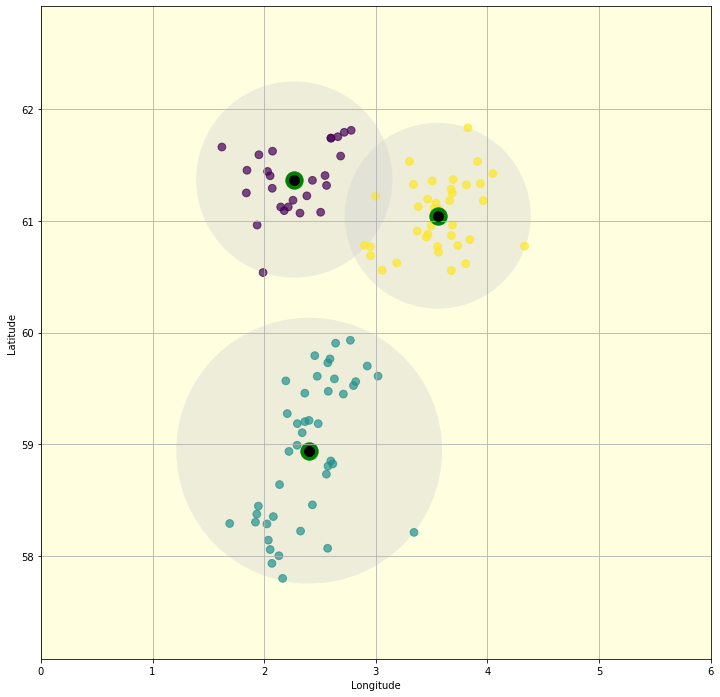

In [8]:
fig = plt.figure(figsize=((12,12)))
plot_kmeans(kmeans, X)
ax = plt.gca()
ax.set_facecolor('lightyellow')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_xlim(0,6)
ax.set_ylim(57,63)
plt.grid();

#### Determining number of clusters

The result shown above seems reasonable, but let's try to take a step back and see if we can determine the number of clusters automatically. Below I use two different methods: the silouhette analysis and the Calinski-Harabaz Index.

#### Silhouette analysis

In [9]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9]

For n_clusters = 2 The average silhouette_score is : 0.6065110340356796
For n_clusters = 3 The average silhouette_score is : 0.600371521317385
For n_clusters = 4 The average silhouette_score is : 0.5766168342704476
For n_clusters = 5 The average silhouette_score is : 0.5526472065500782
For n_clusters = 6 The average silhouette_score is : 0.45743043992085897
For n_clusters = 7 The average silhouette_score is : 0.41906584905151656
For n_clusters = 8 The average silhouette_score is : 0.42521663875581056
For n_clusters = 9 The average silhouette_score is : 0.448706593735551


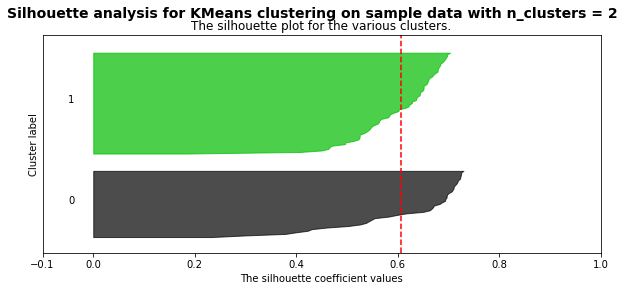

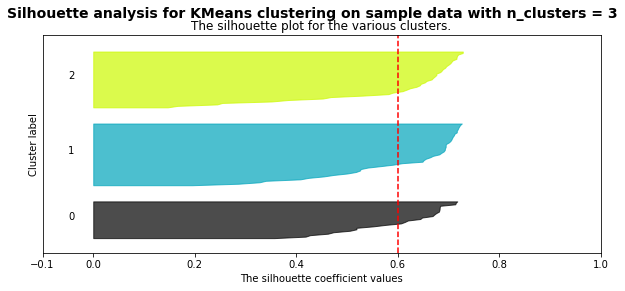

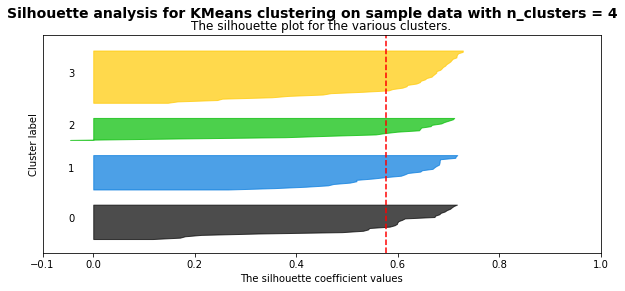

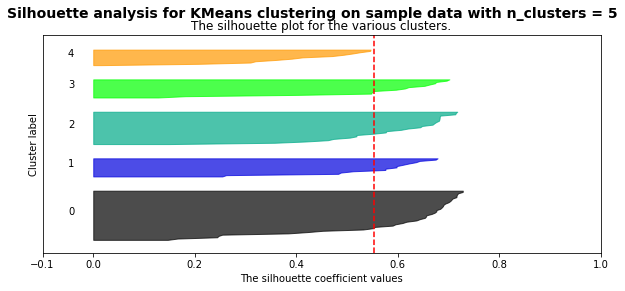

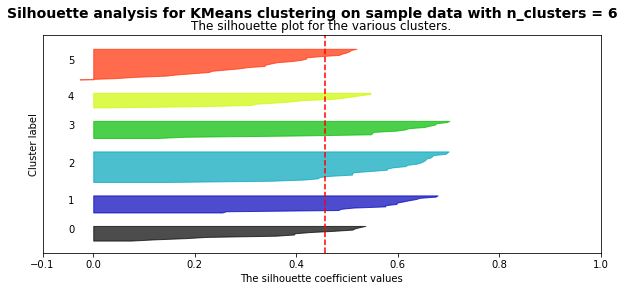

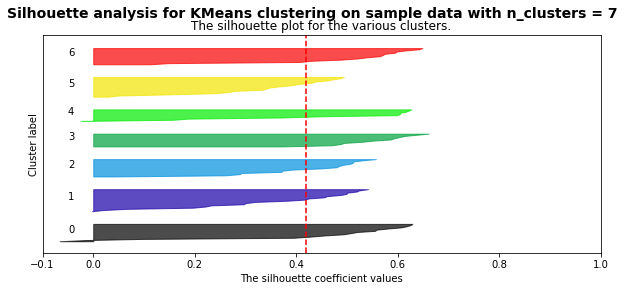

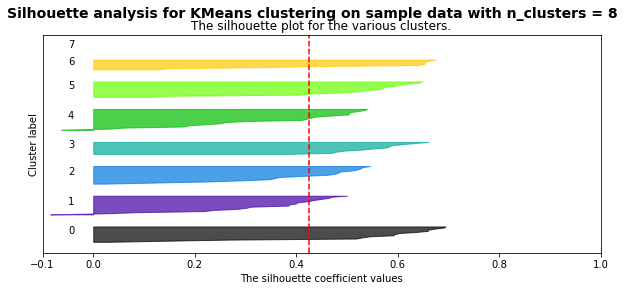

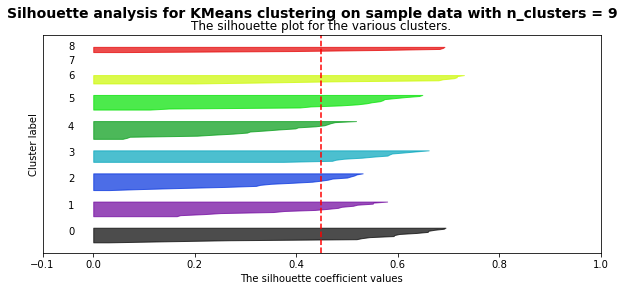

In [10]:
# Generating the sample data from make_blobs

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots()
    fig.set_size_inches(10, 4)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show();

Tha analysis suggests 2 or 3 clusters may be a good choice, with an average `silhouette_score` of  is : 0.6065 for two clusters, just a bit higher than the score for 3 clusters, which is 0.6004.

#### Calinski-Harabaz Index

In [11]:
cluster_CH = []
for num_clusters in range_n_clusters:
      clusters = KMeans(num_clusters)
      cluster_CH.append(calinski_harabasz_score(X, clusters.fit( X ).labels_))

In [12]:
clusters_CH_df = pd.DataFrame({ "num_clusters":range_n_clusters, "cluster_CH": cluster_CH })

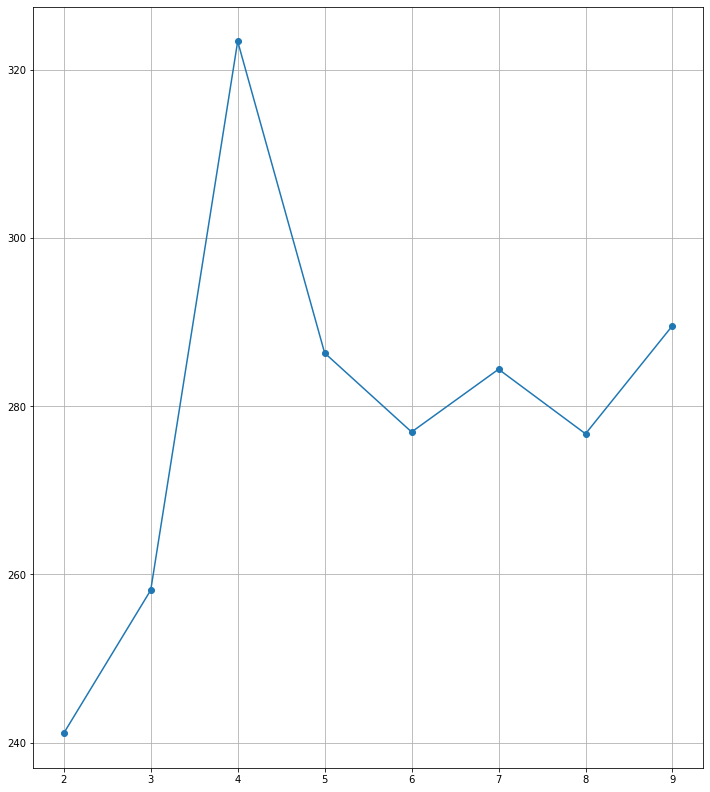

In [13]:
plt.figure(figsize=(12,14))
plt.plot(clusters_CH_df.num_clusters, clusters_CH_df.cluster_CH, marker = "o")
plt.grid();

The CH index actually would suggest 4 clusters. It is possible that we might be better off splititng the the southern-most, elongated cluster into two sub-clusters.
But before moving forward, I am going to look at Gaussin Mixture Models, because of its two advantages: cluster probabilities, and its better handling of non-circular clusters.

#### Let's try with GMM

#### Determining number of clusters

I will be using a number of metrics: BIC, AIC, and log-likelyhood.

In [14]:
n_components = np.arange(1, 10)

models = [mixture.GaussianMixture(n, covariance_type='full', random_state=3425).fit(X)
          for n in n_components]

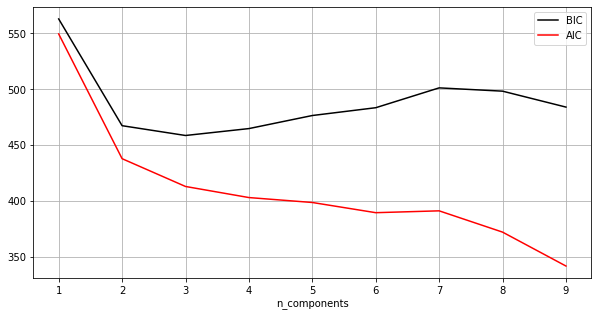

In [15]:
fig = plt.figure(figsize=((10,5)))
plt.plot(n_components, [m.bic(X) for m in models], 'k', label='BIC')
plt.plot(n_components, [m.aic(X) for m in models], 'r', label='AIC')
plt.legend(loc='best')
plt.grid()
plt.xticks(np.arange(1, 10))
plt.xlabel('n_components');

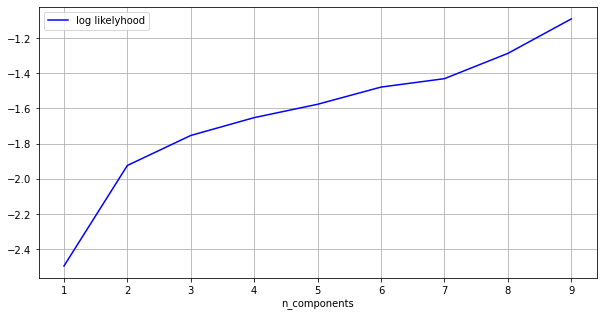

In [16]:
fig = plt.figure(figsize=((10,5)))
plt.plot(n_components, [m.score(X) for m in models], 'b', label='log likelyhood')
plt.legend(loc='best')
plt.grid()
plt.xticks(np.arange(1, 10))
plt.xlabel('n_components');

BIC suggests 3 clusters as optimal, AIC, 3 perhaps 4; one may say that the log-likelyhood plot starts plateauing at 3 clusters but the latter two are subjective.

One thing it is worth trying is to vary the random seed at each iteration (each specific number of clusters), then  examining the spread as an additional measure of stability, an idea I got from reading [this article](https://towardsdatascience.com/gaussian-mixture-model-clusterization-how-to-select-the-number-of-components-clusters-553bef45f6e4).

In [17]:
n_components = np.arange(1, 41)
rand_states = np.random.default_rng().choice(3000, size=40, replace=False)
print(rand_states)

[1715 1498 2299 2840  757  266 1712  610 2480  778 1792  812  691 1786
 2447  188  549  568   66 2785 1252 1772 1991  882 2342 1839 2492 2665
 2881  902  133 2726 1443  863 1642 2973 1367  878  463 1242]


In the cell below I create 40 distinct colours using [I Want Hue](https://medialab.github.io/iwanthue/), a tool suggested on [this Stack Overflow answer](https://stackoverflow.com/a/53141256/1034648).

In [18]:
colors = ['#aa4b51', '#61c350', '#7d63df', '#9dbb35', '#9a3eae', '#3c9238', '#cd41a7', '#4ac07b', '#c674e4', '#5b8b28', '#5155bc', '#c5ad3b',
          '#6b85e9', '#dd962f', '#7457a9', '#878f2a', '#e081d2', '#38793f', '#d64587', '#66cba6', '#de4461', '#3abec8', '#c6402e', '#56a6db', 
          '#dc6c2f', '#4871b2', '#9db76e', '#ab5e9e', '#469e79', '#99456b', '#277257', '#e387a5', '#5a6825', '#ae99dd', '#896827', '#7f5696', 
          '#d4a366', '#9f5a2b', '#8f8a4a', '#e3856b']

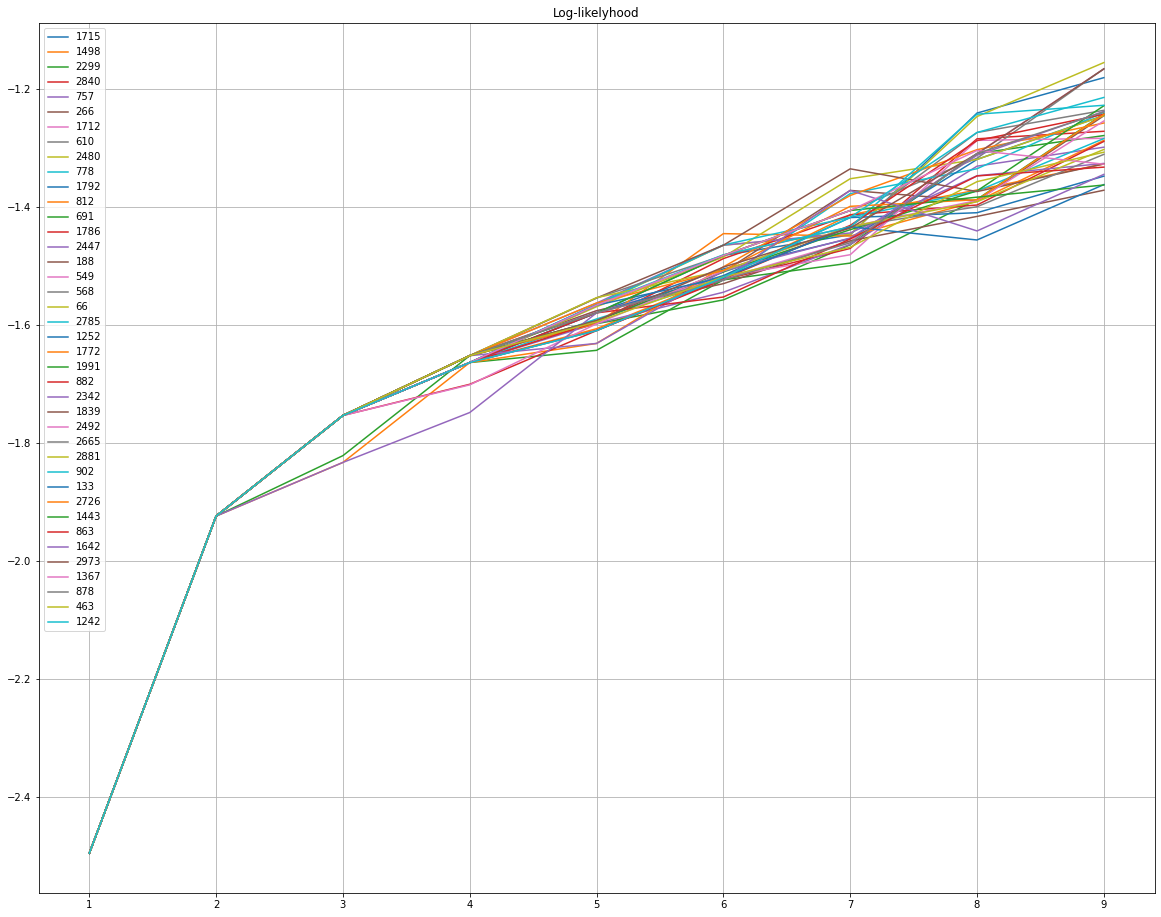

In [19]:
fig = plt.figure(figsize=((20,16)));
plt.style.context({"axes.prop_cycle" : plt.cycler("color", colors)})
for c, r in enumerate(rand_states):
    scores = []
    for n in np.arange(1, 10):       
        model = mixture.GaussianMixture(n, covariance_type='full', random_state=r).fit(X)
        scores.append(model.score(X))
    plt.plot(np.arange(1, 10), scores, label = str(r));
plt.grid();
plt.xticks(np.arange(1, 10));
plt.legend();
plt.title('Log-likelyhood')
plt.show()
#plt.savefig('Log-likelihoods.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

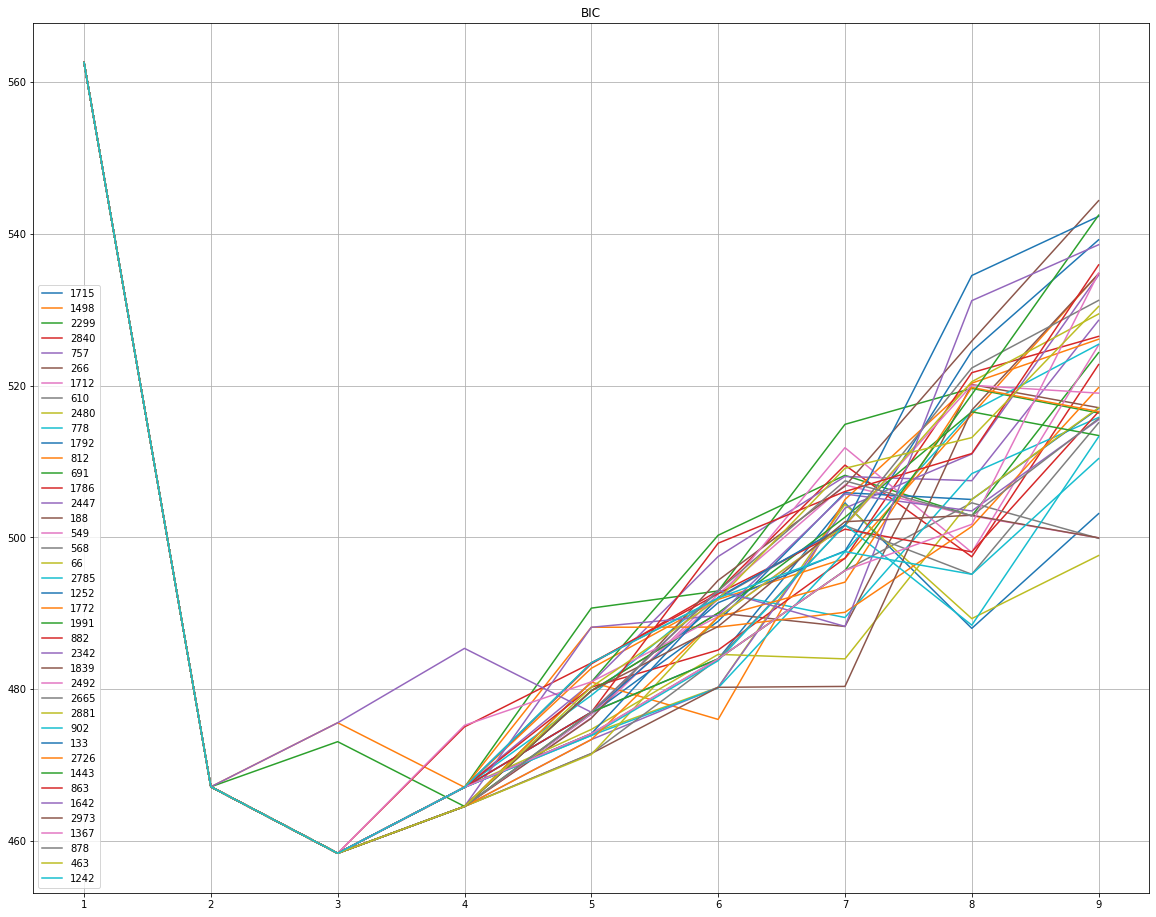

In [20]:
fig = plt.figure(figsize=((20,16)));
for c, r in enumerate(rand_states):
    scores = []
    for n in np.arange(1, 10):       
        model = mixture.GaussianMixture(n, covariance_type='full', random_state=r).fit(X)
        scores.append(model.bic(X))
    plt.plot(np.arange(1, 10), scores,  label = str(r));
plt.grid();
plt.xticks(np.arange(1, 10));
plt.legend();
plt.title('BIC')
plt.show()
#plt.savefig('BICs.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

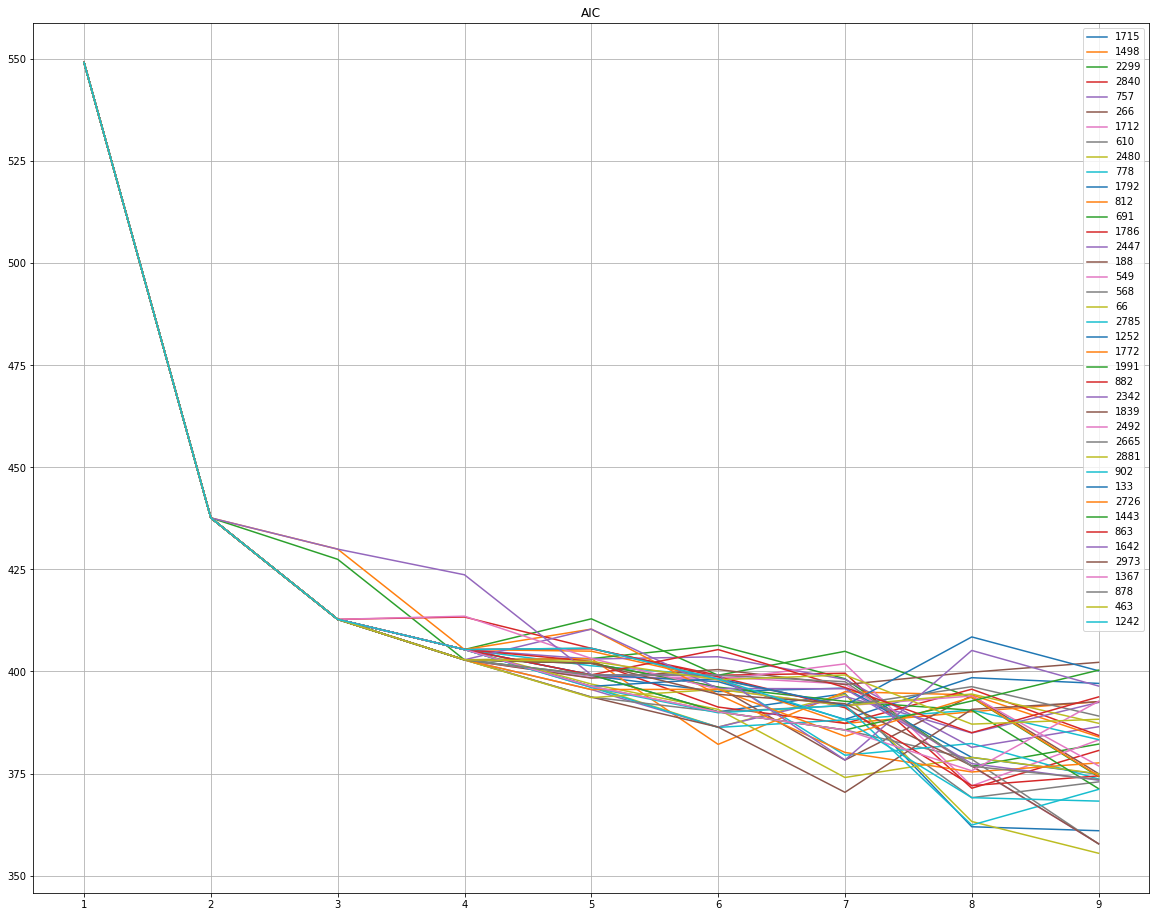

In [21]:
fig = plt.figure(figsize=((20,16)));
for c, r in enumerate(rand_states):
    scores = []
    for n in np.arange(1, 10):       
        model = mixture.GaussianMixture(n, covariance_type='full', random_state=r).fit(X)
        scores.append(model.aic(X))
    plt.plot(np.arange(1, 10), scores, label = str(r));
plt.grid();
plt.xticks(np.arange(1, 10));
plt.legend();
plt.title('AIC')
plt.show();
#plt.savefig('AICs.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

#### Let's go with 3 components

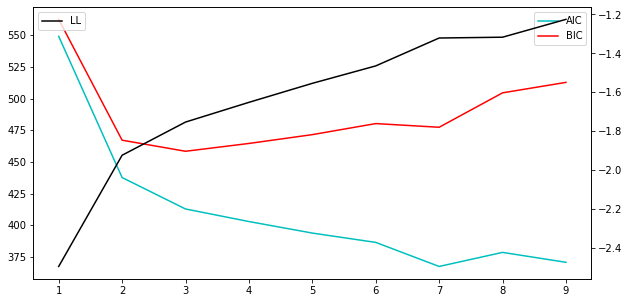

In [22]:
fig, ax = plt.subplots(figsize=((10,5)));
BIC_score=[]
AIC_score=[]
LL_score=[]
for n in np.arange(1, 10):       
    model = mixture.GaussianMixture(n, covariance_type='full', random_state=984).fit(X)
    BIC_score.append(model.bic(X))
    AIC_score.append(model.aic(X))
    LL_score.append(model.score(X))

ax.plot(np.arange(1, 10), AIC_score, color='c', label = 'AIC')
ax.plot(np.arange(1, 10), BIC_score, color='r', label = 'BIC')
plt.legend()
ax2=ax.twinx()
ax2.plot(np.arange(1, 10), LL_score, color='k', label = 'LL')
plt.legend()
plt.show()

It looks like with `random_state=984` 3 clusters is the optima lsolotion so let's use this number.

In [23]:
gmm = mixture.GaussianMixture(n_components=3, covariance_type='full', random_state=2698).fit(X)

#### Checking the class vector

In [24]:
gmm.predict(X)+1

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 1, 1])

#### Checking some probabilities

In [25]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

In [26]:
probs = gmm.predict_proba(X)

In [27]:
probs[np.where((probs.max(axis=1)<0.995 )&(probs.max(axis=1)>0.9))]

array([[0.000, 0.016, 0.984],
       [0.951, 0.049, 0.000],
       [0.006, 0.003, 0.992],
       [0.969, 0.002, 0.029]])

In [28]:
probs[np.where(probs.max(axis=1)<0.9)]

array([[0.895, 0.098, 0.007],
       [0.857, 0.125, 0.018],
       [0.851, 0.146, 0.003],
       [0.832, 0.167, 0.000],
       [0.810, 0.014, 0.175]])

It looks like there's only very few wells for which the probability for the most likely cluster is significantly lower than 95%. And the lowest one is 81% (for cluster 1, with 1.4% and 17.5%, respectively, for cluster 2 and cluster 3.

So, using GMM to get probabilities may be overkill in this instance, but nonetheless I found it useful to get through this exercise to establish a metodology and put together a pipeline, for future use.

In [29]:
# uncomment below to look at the entire 2D array
#print(probs)

#### PLOT

1. #### clusters and size of points by probability
2. #### clusters and ellipses based on the GMM output

Again, adapted from [In Depth: Gaussian Mixture Models](https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html). In the first plot we emphasize difference in probability by sizing dots with `size = 75 * probs.max(1) ** 5`

In [30]:
labels = gmm.predict(X)+1

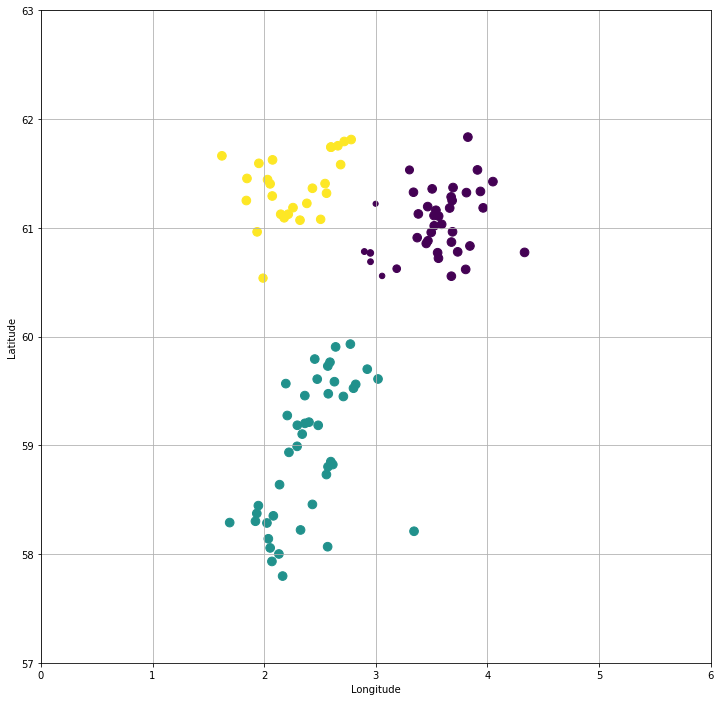

In [31]:
fig = plt.figure(figsize=(12,12))
sizes = 75 * probs.max(1) ** 5 
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=sizes)
ax = plt.gca()
ax.set_facecolor('white')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_xlim(0,6)
ax.set_ylim(57,63)
plt.grid();

In this second plot we look at the covarince ellipses.

In [32]:
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    fig = plt.figure(figsize=((12,12)))
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)

    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor, facecolor = 'darkgreen', edgecolor ='darkslategray')

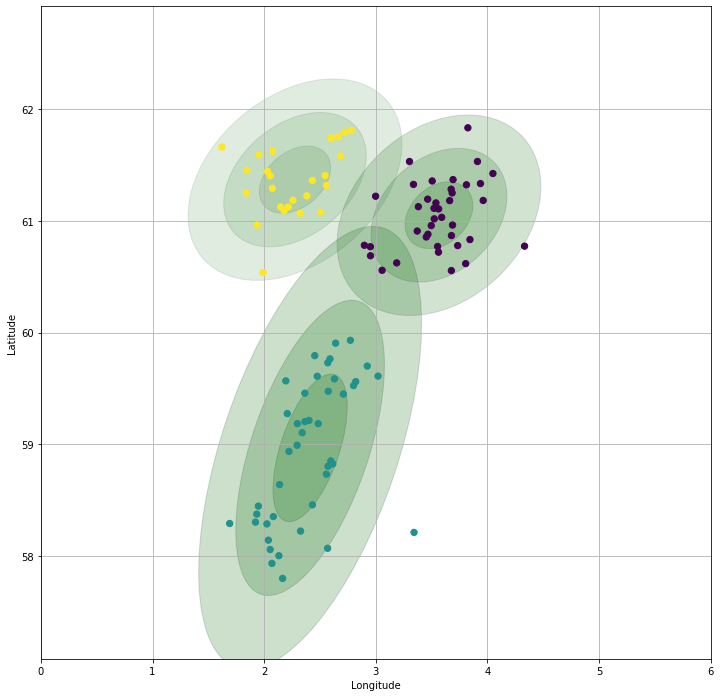

In [33]:
plot_gmm(gmm, X)
ax = plt.gca()
ax.set_facecolor('white')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_xlim(0,6)
ax.set_ylim(57,63)
plt.grid();

#### Encoding the probabilities to a single feature

In [34]:
probs_str=[]
for i in probs:
    probs_str.append([str(j) for j in np.round(i, 3)])

#### Make new DataFrame

In [35]:
data_gmm = data.copy()

Adding encoded probabilities column, a cluster label column, a size column, and also individual cluster porbabilities.

In [36]:
data_gmm['probs_str'] = probs_str
data_gmm['cluster'] = labels
data_gmm['plot_size']= sizes
data_gmm['cluster1_prob'], data_gmm['cluster2_prob'], data_gmm['cluster3_prob'] = np.round(probs.T, 3)

In [37]:
columns = list(data)+[ 'cluster', 'color', 'plot_size', 'probs_str',
                      'cluster1_prob', 'cluster1_prob', 'cluster1_prob']

#### Export

In [38]:
data_gmm.to_csv('clusters_gaussian-mixture-model_3components.csv', sep=',')